# Lesson 5: Bayesian Data Analysis

## Intro to Quantified Cognition

By: Per B. Sederberg, PhD

<a href="https://colab.research.google.com/github/compmem/QuantCog/blob/2022_Fall/notebooks/05_Bayesian_Data_Analysis.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

## Lesson plan

- Introduction to Differential Evolution
- Application to BEST
- Extension of BEST
- Introduce Bayesian regression
- Example with simulated data
- Robust regression (likely next class)


## Differential Evolution

- Instead of random proposals for each new generation, bases proposals on the entire population:

![](https://upload.wikimedia.org/wikipedia/commons/e/e0/Ackley.gif)

## Differential Evolution Monte Carlo (DEMC)

Each new proposal is based on a *difference* between two other particles:

$$x'_i = x_i + \gamma * (x_j - x_k)$$

With the two reference particles ($x_j$ and $x_k$) selected at random from a pool that is not being updated, then the proposals will have symmetric transition probability.

New proposals will take larger steps in the direction with greater range of previously accepted particles.

## RunDEMC

I wrote a library for running DEMC. You can look at the source code here:

https://github.com/compmem/RunDEMC/

## Installling RunDEMC (especially on Google Colab)

In [ ]:
# to install RunDEMC
!pip install fastprogress
!pip install KDEpy
!pip install arviz
!pip install git+https://github.com/compmem/RunDEMC.git


## Using computers to test hypotheses

In [1]:
# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats

import arviz as az


In [2]:
# load pieces from RunDEMC
from RunDEMC import Model, Param, dists
from RunDEMC.io import arviz_dict

## Simple test to verify RunDEMC works

In [3]:
# define a likelihood function that evaluates an entire proposed population
def like_fun(pop, *args):
    # evaluate the model given the params
    # in this case the params are the points where we're evaluating the model
    return np.log(dists.normal(-.5, 0.5).pdf(pop)).sum(1)

# set up the model
params = [Param(name='mu', prior=dists.normal(0, 2.0))]
m = Model('test', params=params,
          like_fun=like_fun,
          pop_recarray=False,
          verbose=True)

# run the model, first with some burnin
times = m.sample(100, burnin=True)
times = m.sample(600, burnin=False)

Initializing: 20(20) 
Iterations (100):


Iterations (600):


## Use ArviZ for evaluation and visualization

![https://arviz-devs.github.io/arviz/](https://arviz-devs.github.io/arviz/_static/logo.png)

In [4]:
# convert the RunDEMC model to ArviZ Inference data
daz = az.from_dict(**arviz_dict(m, burnin=200, step=7))

In [5]:
daz

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

### Show a summary of the inference

In [6]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.467,0.517,-1.424,0.513,0.014,0.01,1412.0,1406.0,1.0


### Plot the posterior and prior

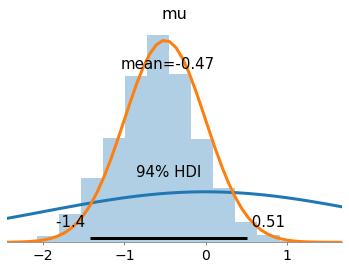

In [7]:
# plot the posterior and prior
az.plot_posterior(daz, kind='hist', density=True)
x = np.linspace(-4,4,100)
plt.plot(x, params[0].prior.pdf(x), '-', lw=3)
plt.plot(x, dists.normal(-.5, 0.5).pdf(x), '-', lw=3)

## Quick paired t-test example with RunDEMC

Ttest_1sampResult(statistic=2.064587710828628, pvalue=0.04992944820805984)

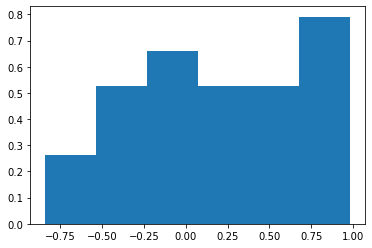

In [8]:
# generate some data that may or may not be significantly different from zero
A = dists.normal(.3, .5).rvs(25)

# plot it
plt.hist(A, bins='auto', density=True);

# do a one-sample t-test
import scipy.stats as stats

stats.ttest_1samp(A, 0.0)

### Set up the model (likelihood and params)

In [9]:

# Define a likelihood function
def students_like(pop, *args):
    # pull the dat out of the args
    dat = args[0]
    
    # fix degrees of freedom
    df = len(dat) - 1
    
    # instantiate the model with the params, 
    # the df is determined from the data
    dist = dists.students_t(pop['mu'][:, np.newaxis], 
                            pop['sigma'][:, np.newaxis], 
                            df)
    
    # calc the log like and sum across items
    log_like = np.log(dist.pdf(dat)).sum(1)
    log_like[np.isnan(log_like)] = -np.inf
    
    # return the log like for each proposal
    return log_like

# set up the model
params = [Param(name='mu', prior=dists.normal(A.mean(), A.std()*2.0)),
          Param(name='sigma', prior=dists.halfcauchy(5))]

m = Model('t-test', params=params,
          like_fun=students_like,
          like_args=(A,),
          verbose=True)

# run the model, first with some burnin
times = m.sample(100, burnin=True)
times = m.sample(900, burnin=False)

Initializing: 40(40) 
Iterations (100):


Iterations (900):


### Convert to ArviZ and evaluate

In [10]:
daz = az.from_dict(**arviz_dict(m, burnin=400, step=1))

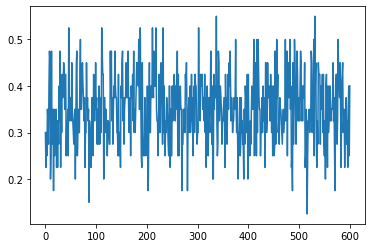

In [11]:
plt.plot(daz.sample_stats.acceptance_rate.T);

In [12]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.214,0.110,-0.000,0.414,0.002,0.001,2962.0,3004.0,1.01
sigma,0.528,0.086,0.378,0.693,0.002,0.001,2426.0,2628.0,1.02


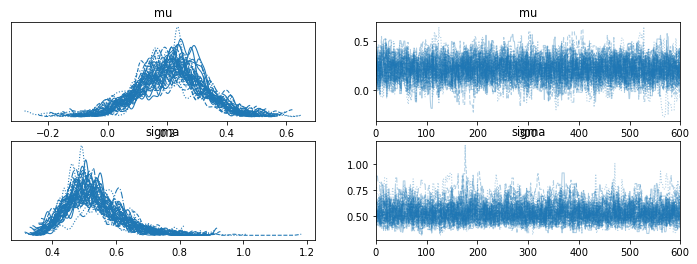

In [13]:
# check our trace
az.plot_trace(daz);

<AxesSubplot:title={'center':'mu'}>

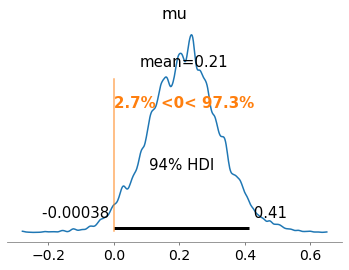

In [14]:
# plot the posterior of the mean
az.plot_posterior(daz, var_names=['mu'], ref_val=0.0)

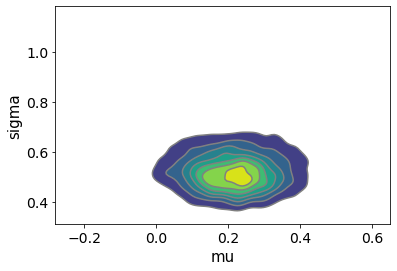

In [15]:
# plot the joint posterior of the two params
az.plot_pair(daz, kind='kde');

## Independent BEST

Let's extend the example to independent samples!!!


Ttest_indResult(statistic=-0.933622277114403, pvalue=0.3616343607272413)

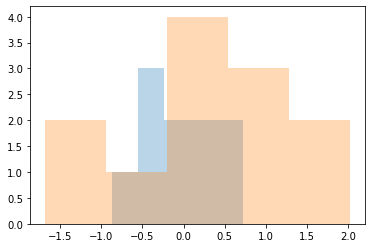

In [16]:
# generate some data that may or may not be significantly different from each other
A = dists.normal(mean=0.2, std=0.5).rvs(10)
B = dists.normal(mean=0.8, std=1.0).rvs(12)

# plot it
plt.hist(A, bins='auto', alpha=0.3);
plt.hist(B, bins='auto', alpha=0.3);

# do a quick t-test
stats.ttest_ind(A, B)

### Thinking more about priors

In [17]:
# first get overall mean and std
overall_mean = np.append(A, B).mean()
overall_std = np.append(A, B).std()
print('overall_mean:', overall_mean)
print('ovearll_std:', overall_std)

overall_mean: 0.1516140993571805
ovearll_std: 0.8682209701760814


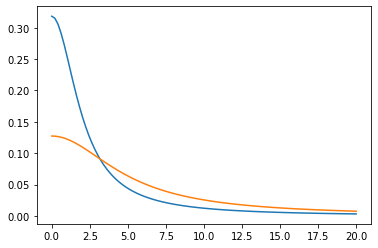

In [18]:
# explore the half Cauchy prior for std param
x = np.linspace(0, 20, 100)
plt.plot(x, dists.halfcauchy(scale=2).pdf(x))

plt.plot(x, dists.halfcauchy(scale=5).pdf(x))

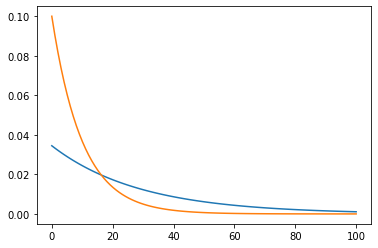

In [19]:
# exponential prior for degrees of freedom (nu)
x = np.linspace(0, 100, 100)
plt.plot(x, dists.exp(1/29.).pdf(x))
plt.plot(x, dists.exp(.1).pdf(x))

In [20]:
# Define a likelihood function
def ind_students_like(pop, *args):
    # pull the dat out of the args
    datA = args[0]
    datB = args[1]
    
    # instantiate the model with the params, 
    distA = dists.students_t(pop['mu_A'][:, np.newaxis], 
                             pop['sigma_A'][:, np.newaxis], 
                             pop['nu'][:, np.newaxis])
    distB = dists.students_t(pop['mu_B'][:, np.newaxis], 
                             pop['sigma_B'][:, np.newaxis], 
                             pop['nu'][:, np.newaxis])
    
    # calc the log like and sum across obs
    log_like = np.log(distA.pdf(datA)).sum(1)
    log_like += np.log(distB.pdf(datB)).sum(1)
    log_like[np.isnan(log_like)] = -np.inf
    
    # return the log like for each proposal
    return log_like

# set up the model
params = [Param(name='mu_A', prior=dists.normal(overall_mean, overall_std*2.0)),
          Param(name='mu_B', prior=dists.normal(overall_mean, overall_std*2.0)),
          Param(name='sigma_A', prior=dists.halfcauchy(5)),
          Param(name='sigma_B', prior=dists.halfcauchy(5)),
          Param(name='nu', prior=dists.exp(1/29.), 
                transform=lambda x: x + 1,
                inv_transform=lambda x: x - 1)]

# set up DE
m = Model('t-test_ind', 
          params=params,
          like_fun=ind_students_like,
          like_args=(A, B),
          verbose=True)

# run the model, first with some burnin
times = m.sample(100, burnin=True)
times = m.sample(1600, burnin=False)

Initializing: 100(100) 
Iterations (100):


Iterations (1600):


/home/per/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6315: RuntimeWarning: overflow encountered in power
  / (np.sqrt(r*np.pi)*(1+(x**2)/r)**((r+1)/2)))
/tmp/ipykernel_987304/1845492838.py:16: RuntimeWarning: divide by zero encountered in log
  log_like = np.log(distA.pdf(datA)).sum(1)


In [21]:
daz = az.from_dict(**arviz_dict(m, burnin=400, step=7))

In [22]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_A,-0.041,0.195,-0.418,0.321,0.003,0.002,5288.0,5962.0,1.02
mu_B,0.323,0.360,-0.381,0.986,0.005,0.003,5475.0,8150.0,1.01
sigma_A,0.571,0.175,0.306,0.886,0.003,0.002,4256.0,4643.0,1.02
sigma_B,1.206,0.320,0.704,1.817,0.005,0.004,4574.0,5412.0,1.02
nu,36.128,30.217,1.771,91.537,0.543,0.384,4503.0,4810.0,1.02


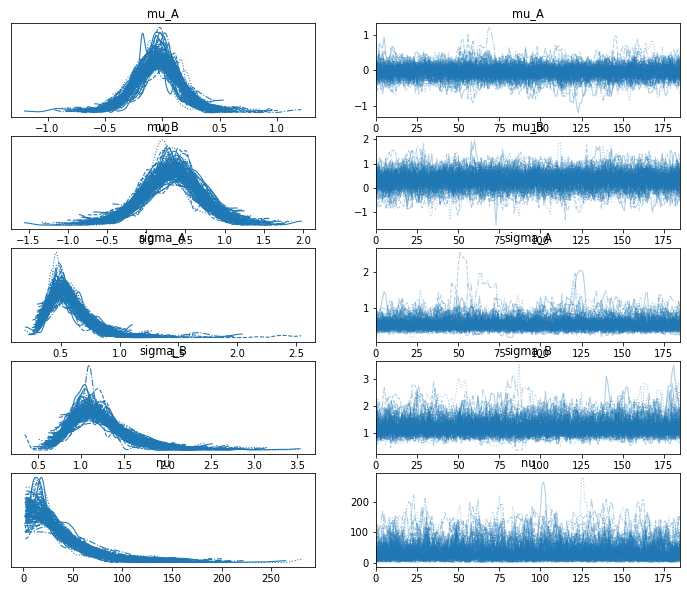

In [23]:
# check our trace
az.plot_trace(daz);

### You can compare posteriors to test hypotheses!!!

In this case we want to know whether the means and/or standard deviations are different for the two sets of observed data.

In [24]:
# we care about differences in posteriors now
post = daz.posterior
post['mu_B - mu_A'] = post['mu_B'] - post['mu_A']
post['sigma_B - sigma_A'] = post['sigma_B'] - post['sigma_A']
post['mu_B - mu_A'] = post['mu_B'] - post['mu_A']
post['effect_size'] = post['mu_B - mu_A'] / \
                      np.sqrt((post['sigma_A']**2 + post['sigma_B']**2) / 2)

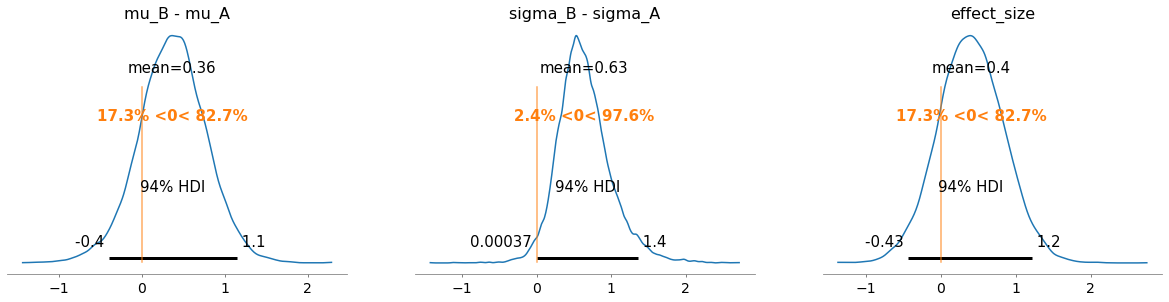

In [25]:
# plot the posterior of the mean
az.plot_posterior(daz, var_names=['mu_B - mu_A', 'sigma_B - sigma_A', 'effect_size'], 
                  ref_val=0.0);

## Linear Regression

One of the most common and flexible statistical approaches.

Involves building a model that can predict the dependent data ($y$) based on different combinations of independent data ($x$):

$$y = \beta_0 + \beta_1 x + \epsilon$$


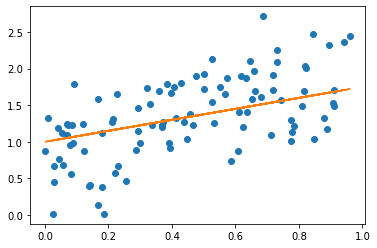

In [26]:
# generate some data with a linear trend
nsamples = 100
true_slope = 0.75
true_intercept = 1.0
true_sigma = 0.5

# uniform sampling over x
x = dists.uniform(0, 1).rvs(nsamples)

# apply noise to linear model
y_true = true_intercept + true_slope*x 
y = y_true + dists.normal(mean=0.0, std=true_sigma).rvs(nsamples)

# set the data
data = pd.DataFrame(dict(x=x, y=y))

# plot the data
plt.plot(x, y, 'o')
plt.plot(x, y_true, '-')

In [27]:
# let's look at the data
data.head()

,x,y
0,0.532798,1.257216
1,0.405664,1.749774
2,0.052711,1.119302
3,0.395651,1.670780
4,0.686456,2.714147


In [28]:
# Define a likelihood function for the linear model
def lm_like(pop, *args):
    # pull the dat out of the args
    dat = args[0]

    # get the predictions from the model for all proposals
    xdata = args[0]['x'].to_numpy()
    ydata = args[0]['y'].to_numpy()
    ymodel = (pop['alpha'] + pop['beta']*xdata[:, np.newaxis]).T

    # fit normal distribution around each predicted y
    dist = dists.normal(ymodel, 
                        pop['sigma'][:, np.newaxis])
    
    # calc the log like and sum across obs
    log_like = np.log(dist.pdf(ydata)).sum(1)
    log_like[np.isnan(log_like)] = -np.inf
    
    # return the log like for each proposal
    return log_like

# set up the model
params = [Param(name='alpha', prior=dists.normal(0, 20)),
          Param(name='beta', prior=dists.normal(0, 20)),
          Param(name='sigma', prior=dists.halfcauchy(10))]

m = Model('t-test', params=params,
          like_fun=lm_like,
          like_args=(data,),
          verbose=True)

# run the model, first with some burnin
times = m.sample(100, burnin=True)
times = m.sample(1200, burnin=False)

Initializing: 60(60) 1(1) 
Iterations (100):


/tmp/ipykernel_987304/2756849727.py:16: RuntimeWarning: divide by zero encountered in log
  log_like = np.log(dist.pdf(ydata)).sum(1)


Iterations (1200):


In [29]:
daz = az.from_dict(**arviz_dict(m, burnin=400, step=7))

In [30]:
az.summary(daz)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.827,0.084,0.667,0.982,0.001,0.001,4374.0,5500.0,1.01
beta,1.168,0.157,0.874,1.466,0.002,0.002,4568.0,5657.0,1.01
sigma,0.443,0.032,0.384,0.502,0.000,0.000,4615.0,5539.0,1.00


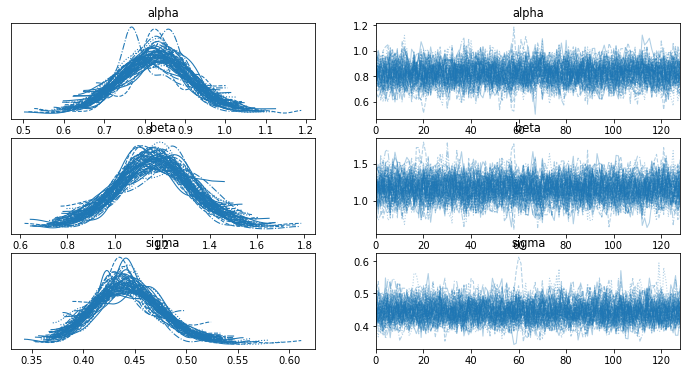

In [31]:
# check our trace
az.plot_trace(daz);

array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

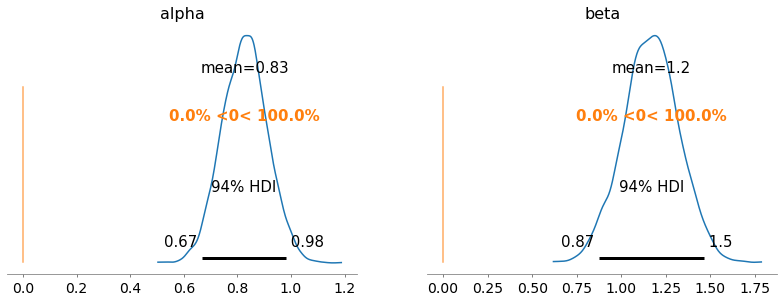

In [32]:
az.plot_posterior(daz, var_names=['alpha', 'beta'], ref_val=0.0)

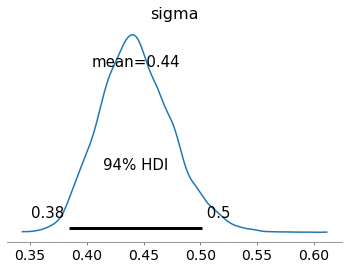

In [33]:
az.plot_posterior(daz, var_names=['sigma']);

## Dealing with outliers

Sometimes data can be messy. You can either assume every observation affects the statistical inference similarly, or you can try and downplay the effect of potential outliers.

This approach is also known as robust regression.


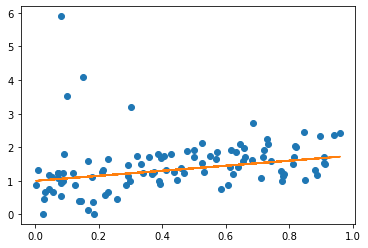

In [34]:
# let's add in some outliers!
x_out = np.append(x, [.08, .1, .15, .3])
y_out = np.append(y, [5.9, 3.54, 4.1, 3.2])

# plot the data
plt.plot(x_out, y_out, 'o')
plt.plot(x, y_true, '-')

## We'll create an outlier model for next class

## Assignment before next class

- An actual Bayesian data analysis!

### See you next week!!!